##  Statistical Analyses of Github Users'  Acvitivities for Predicting Target Number of Commits

David Yang 
July 15, 2017

## 1. Import Trainning Data and Testing Data


In [167]:
# Load in the python packages and specify interface parameters  
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, RidgeCV, ElasticNet, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 25

# Read in the train_data files into Pandas DataFrames. 
# Due to reasons as explained in Exploratory Data Analyses, use X1-X6 to mark the firt 6 variables other than 'huid'. 
COLUMN_NAMES = ['huid', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'days_since_commit_comment', 'total_commits', 
                'total_inline_pr_comments', 'days_since_inline_pr_comment', 'total_issue_comments', 
                'days_since_issue_comment', 'total_issues', 'issue_titles', 'days_since_issue', 'total_prs', 
                'pr_titles', 'days_since_pr', 'total_pushes', 'days_since_push']

Train_DataFrame = pd.read_csv('train_data.tsv', sep='\t', skiprows = 1, index_col = 0,  names = COLUMN_NAMES+['target_commits'])
Test_DataFrame  = pd.read_csv('test_data.tsv',  sep='\t', skiprows = 1, index_col = 0,  names = COLUMN_NAMES)

# Merge activity metrics (predictor variables) from Training Data and Testing Data
All_X_Data   = pd.concat((Train_DataFrame.iloc[:, :20], Test_DataFrame.iloc[:, :20]))

# Create an additional outcome variable called 'target_positive' ("1" if target_commits>0; "0" otherwise)
Train_Y_Data = Train_DataFrame[['target_commits']]
Train_Y_Data[['target_positive']] = Train_Y_Data[['target_commits']].applymap(lambda x: 1 if x > 0 else 0)

# Create lists of different types of variables that will be used later for analyses. 
NUMERICAL_PREDICTORS = [x for x in All_X_Data.columns if All_X_Data.dtypes[x] != 'object']; 
TEXT_PREDICTORS      = ['issue_titles', 'pr_titles']
OUTCOME_VARIABLE     = ['target_commits', 'target_positive']
DAYS_PREDICTORS      = [x for x in All_X_Data.columns.values.tolist() if x.startswith("days")]
NONDAYS_PREDICTORS   = [x for x in NUMERICAL_PREDICTORS if x not in DAYS_PREDICTORS]       

## 2. Data Cleaning and Feature Engineering

In [168]:
# Exclude the two predictors with so many missing values (around 50% or more)
NUMERICAL_PREDICTORS = [x for x in NUMERICAL_PREDICTORS if x not in ["days_since_inline_pr_comment", "days_since_commit_comment"]]
DAYS_PREDICTORS      = [x for x in DAYS_PREDICTORS if x not in ["days_since_inline_pr_comment", "days_since_commit_comment"]]
All_X_Data = All_X_Data[NUMERICAL_PREDICTORS + TEXT_PREDICTORS]

# For the other 4 days-related variables, impute missingness by column-wise median values 
All_X_Data[DAYS_PREDICTORS] = All_X_Data[DAYS_PREDICTORS].fillna( All_X_Data[DAYS_PREDICTORS].median() )

# Apply Log(1+x) transformation to 'target_commits' and NONDAYS_PREDICTORS
Train_Y_Data[['target_commits']] = np.log1p(Train_Y_Data[['target_commits']])
All_X_Data[NONDAYS_PREDICTORS]   = All_X_Data[NONDAYS_PREDICTORS].applymap(lambda x: np.log1p(x))

# Derive Binary Variables to mark level of activity ("1" if active; "0" otherwise) for some variables 
NONDAYS_TO_BE_TRANSFORM   = ['x4', 'x5', 'x6', 'total_inline_pr_comments', 'total_issues', 'total_prs', 'total_pushes']
NONDAYS_BINARY_PREDICTORS = ["bin_" + x for x in NONDAYS_TO_BE_TRANSFORM] 
All_X_Data[NONDAYS_BINARY_PREDICTORS] = All_X_Data[NONDAYS_TO_BE_TRANSFORM].applymap(lambda x: 1 if x > 0 else 0)

# Dichotomize days-related numerical predictors 
DAYS_BINARY_PREDICTORS = ["bin_" + x for x in DAYS_PREDICTORS] 
All_X_Data[DAYS_BINARY_PREDICTORS] = All_X_Data[DAYS_PREDICTORS].applymap(lambda x: 1 if x < 330 else 0)

# Apply power transformation to the 4 days-lated numerical predictors to scale into [0, 1] 
All_X_Data[DAYS_PREDICTORS] = All_X_Data[DAYS_PREDICTORS].applymap(lambda x: (x/365)**4)

# Derive new title features to meaure the relative lengths of titles.
All_X_Data[['issue_titles_len']] = np.log1p(All_X_Data[['issue_titles']].applymap( lambda x: len(x)))
All_X_Data[['pr_titles_len']]    = np.log1p(All_X_Data[['pr_titles']].applymap( lambda x: len(x))) 

# Add the predictors to name lists
NUMERICAL_PREDICTORS += ['issue_titles_len', 'pr_titles_len']
NONDAYS_PREDICTORS += ['issue_titles_len', 'pr_titles_len']

# Dichotimize issue_titles_len and pr_titles_len into binary predictors ("1" if at least one title; "0" otherwise)
All_X_Data[['bin_issue_titles_len']] = All_X_Data[['issue_titles']].applymap( lambda x: 1 if len(x.split(", ")) > 0 else 0) 
All_X_Data[['bin_pr_titles_len']]    = All_X_Data[['pr_titles']].applymap( lambda x: 1 if len(x.split(", ")) > 0 else 0) 

# Add to the name list of binary predictors
BINARY_PREDICTORS = DAYS_BINARY_PREDICTORS + NONDAYS_BINARY_PREDICTORS + ["bin_issue_titles_len", "bin_pr_titles_len"]

# Center and Standardize the NUMERICAL_PREDICTORS 
All_X_Data[NUMERICAL_PREDICTORS] -= All_X_Data[NUMERICAL_PREDICTORS].mean()
All_X_Data[NUMERICAL_PREDICTORS] /= All_X_Data[NUMERICAL_PREDICTORS].std()

# Create Quadratic Terms for all numerical predictors except for the days-related variables
for feature in NONDAYS_PREDICTORS:
    All_X_Data[feature+'_2'] = All_X_Data[feature]**2
QUADRATIC_PREDICTORS = [x for x in All_X_Data.columns.values.tolist() if x.endswith("_2")]

# Center and Standardize the QUADRATIC_PREDICTORS 
All_X_Data[QUADRATIC_PREDICTORS] -= All_X_Data[QUADRATIC_PREDICTORS].mean()
All_X_Data[QUADRATIC_PREDICTORS] /= All_X_Data[QUADRATIC_PREDICTORS].std()

# Create some interactional terms between the paired binary and continuous variables  
for feature in BINARY_PREDICTORS:
    All_X_Data[feature+'_int'] = All_X_Data[feature]*All_X_Data[feature.replace("bin_", "")]
INTERACTION_TERMS = [x for x in All_X_Data.columns.values.tolist() if x.endswith("_int")]

## 3. Compare Feature Space between Training Data and Testing Data

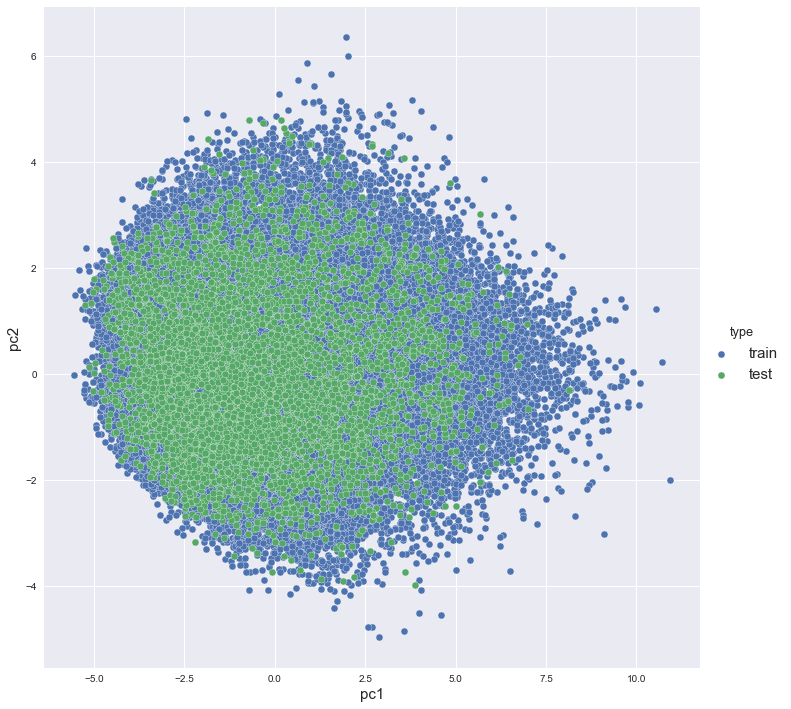

In [170]:
# Conduct PCA to see how much overlap between Test and Train feature spaces 
All_Numerical_X_Data = All_X_Data.loc[:, NUMERICAL_PREDICTORS]
pca = PCA(n_components=2)
pca.fit(All_Numerical_X_Data)

all_pca_df = pd.DataFrame(pca.fit_transform(All_Numerical_X_Data))
all_pca_df.columns = ["pc1", "pc2"]  
all_pca_df['type'] = np.repeat(["train", "test"], [50000, 5000])

# Plot suggests that the two spaces are quite similar to each other
plt.rcParams.update({'legend.fontsize': 15, "axes.labelsize": 15})
sns.pairplot(x_vars=["pc1"], y_vars=["pc2"], data=all_pca_df, hue="type", size=10); plt.show()

In the transformed feature space, after applying Princial Component Analysis, we see that the hold-out data (test_data) features and the training (train_data) features are firly overlapped to each other.  This suggest that the model we learnt from train_data can be applicable to the hold-out data for making prediction. 

/Users/xiaoweiyang/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


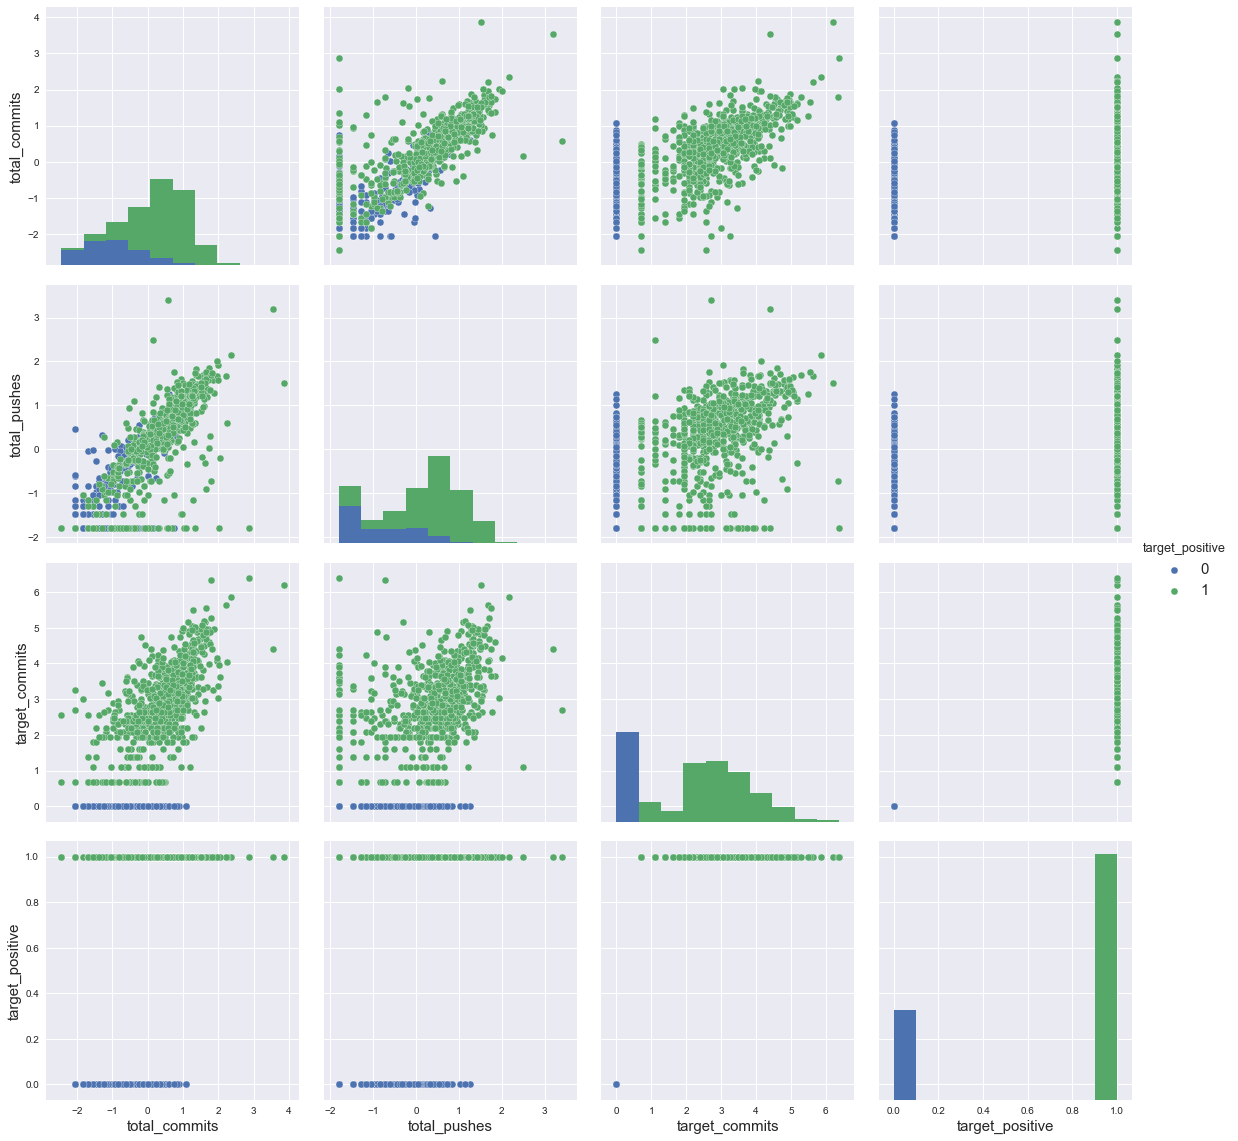

In [225]:
# Scatter Plot to show relations between candidate strong predictors and the targer_commits 
df = Train_X_Data; 
df['target_commits'] = Train_Y_Data['target_commits']; df['target_positive'] = Train_Y_Data['target_positive'] 
sns.pairplot(df[np.random.rand(len(df)) < 0.02][['total_commits','total_pushes','target_commits', 'target_positive']],
             hue="target_positive", size=4); plt.show()

## 4. Prepare Data Matrices for Later Regression Analyses  

In [171]:
# FEATURES list contains all the predictor variables for later modeling
FEATURES = NUMERICAL_PREDICTORS + BINARY_PREDICTORS + QUADRATIC_PREDICTORS + INTERACTION_TERMS

# After Feature Engining and Data Preprocessing, we now split the data back to Train and Tesing sets
Train_X_Data = All_X_Data.iloc[:50000,:]   # Training Features (Don't forget Train_Y_Data)
Test_X_Data  = All_X_Data.iloc[50000:,:]   # Testing Features  

# Split Training Data into Train Subset (for building models) and Validation Subset (for evaluating model performances)
np.random.seed(123)
train_indicators = np.random.rand(len(Train_X_Data)) < 0.7    
X_Train,    y_Train    = Train_X_Data[train_indicators],  Train_Y_Data[train_indicators] 
X_Validate, y_Validate = Train_X_Data[~train_indicators], Train_Y_Data[~train_indicators]

# Further idenity the instances of the Train Subsets that have positive target_commits
active_rows = list(np.where((Train_Y_Data["target_positive"] == 1))[0])
X_Train_Active = Train_X_Data.iloc[active_rows]  # Predictor Values (X) of Instances with target_commits > 0
y_Train_Active = Train_Y_Data.iloc[active_rows]  # Outcome Data (y) of Instances with taregt_commits > 0

Test_X_Data is used for making predictions for final task submission.  

X_Train and y_Train are training subset for building models.  

X_Validate and y_Validate are validation subset for evaluation of the fitted models. 

## 5.  Zero-Inflated Gaussion Mixture Model 

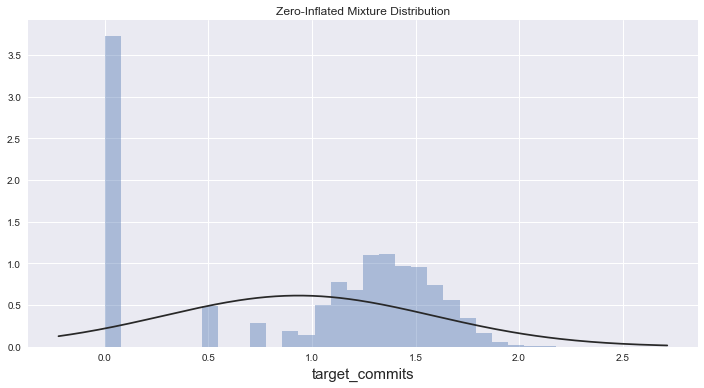

In [172]:
# Zero-inflated Gaussian Distribution for target_commits
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(1,1,1); ax.set_title('Zero-Inflated Mixture Distribution')
sns.distplot(np.log1p(Train_Y_Data['target_commits']), kde=False, fit=stats.norm)

The histgram clearly suggests some vilations from simple normality assumption of the tartget variable:  (1) there are lots of instances with target_commits = 0 (a phenominion called "zero-inflation");  (2) there are also some target_commits, after log(1+x) transformation, have small positive values such as 0.5 and 0.75; (3) the rest values follow a Gaussian distribution centered around 1.4.  

For the time being, this projects assumes two options for the regression analyses: a Zero-Inflated Gaussian (ZIG) distribution OR a simple Gaussian distribution. Note that instances with target_commits of 0.5 and 0.75 (after the logarithm transformation) are not satisfied adopting either option.

Lowest Root Mean Squared Error: 1.05151827016


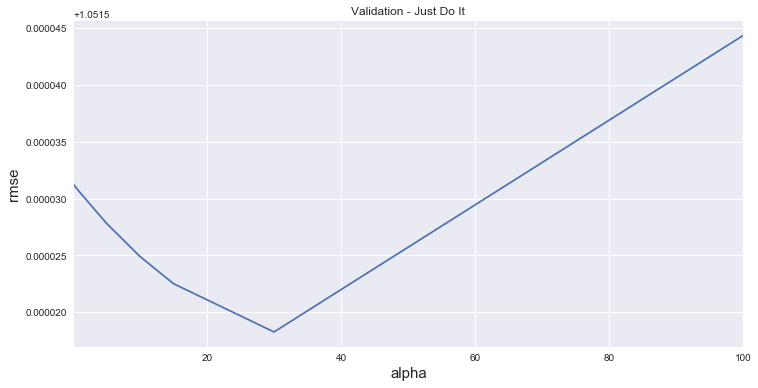

In [226]:
# An illustration for determing tunning parameter (alpha) for the Ridge Regression (L2 regularization)
# Using similar procedure to determin tunning parameters of Lasso and Elastic Net regression 
def rmse_cv(model):
    return np.sqrt( -cross_val_score( model, X_Train[FEATURES], y_Train['target_commits'], 
                                     scoring="neg_mean_squared_error",  cv = 5) )

alphas = [0.1, 0.5, 1, 5, 10, 15, 30, 100]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
plt.figure(figsize=(12, 6))
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha");  plt.ylabel("rmse");

# Show the minimum RMSE 
print("Lowest Root Mean Squared Error: {}".format(cv_ridge.min()))

So long as we have done sufficient feature engineering jobs (of cause, given limited time, this project has not yet done enough), standard linear regression models with L1 and/or L2 regularizations would be a starting point for supervised learning task with continuous outcomes variables. Ridge reggressor usually performs well when the goal is primarily on enhancing the prediction accuracy. If the goal is for variable selection, that Lasso with L1 regularization would be a better choice. The above plot from 5-fold Cross Validation suggests that Alpha = 30 corresponds to minimize RMSE (roor mean squared error). 

In the following, we first assume that target_commits has a ZIG distrion, then **conduct ZIG modeling** in the following steps: 

- ZIG Step 1: Fit a Ridge regressor with Alpha=30 to the instances in Train Subset with positive outcomes (i.e., X_Train_Active and y_Train_Active)

- ZIG Step 2: Fit a Random Forest Clafier using instances from Train Subsets (i.e., X_Train and y_Train) to predict if an isntance would have target_commits of zero or not (i.e., target_positive = 0 or 1).   

- ZIG Step 3: Finally, we use the instances in Validation Sets (i.e., X_Validate and y_Validate) to estimate the performance of this ZIG modeling approach with RMSE measuring the accuracy. 

If the performance of ZIG modeling strategy ends up with smaller RMSE, then we apply it to Test_X_Data for predicting target_commits for final submission. 


### 5.1 ZIG Step 1

Fit a Ridge regressor with Alpha=30 to the instances in Train Subset with positive outcomes (i.e., X_Train_Active and y_Train_Active)

R^2: 0.428706096829
Root Mean Squared Error: 0.816550062211


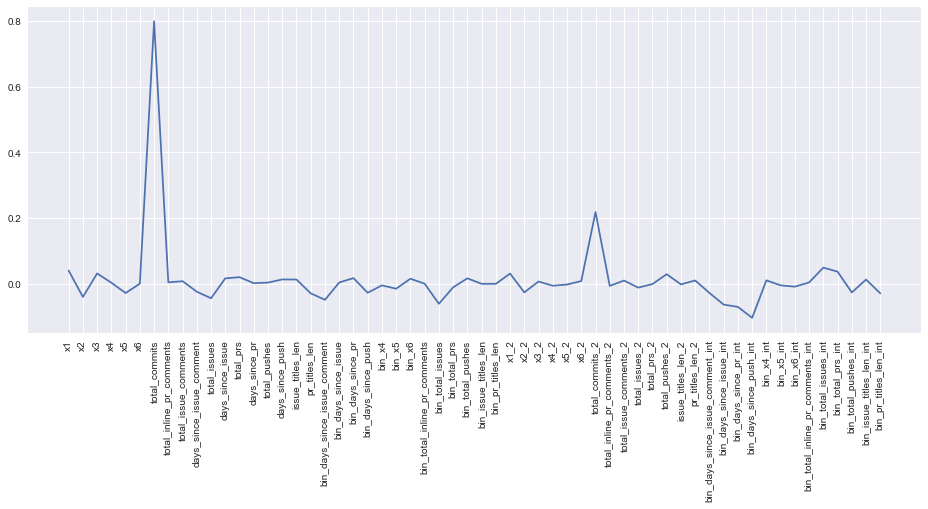

In [227]:
# Split data into Trainning and Validation (called "test" here) 
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_Train_Active[FEATURES],
                                                                    y_Train_Active['target_commits'],
                                                                    test_size = 0.3,  
                                                                    random_state=123)
# Instantiate Pipeline object
ridge_reg = Ridge(alpha = 30)

# Fit training data
ridge_reg.fit(X_train_reg, y_train_reg)

# Predict on test data
y_pred_reg = ridge_reg.predict(X_test_reg)

# Compute and print R^2 and RMSE
print("R^2: {}".format(ridge_reg.score(X_test_reg, y_test_reg)))
rmse = np.sqrt( mean_squared_error(y_test_reg, y_pred_reg) )
print("Root Mean Squared Error: {}".format(rmse))

# Compute and plot the regression coefficients
coef = ridge_reg.coef_
plt.figure(figsize=(16,6))  
plt.plot(range(len(FEATURES)), coef)
plt.xticks(range(len(FEATURES)), FEATURES, rotation=90);  plt.show()

RSME of the Ridge Regressor from ZIG Step 1 is 0.8165, not bad.  The above figure depicts the shrinkage estimates of the regression coefficients of all the 58 features (including original and derived ones). We can clearly observ that **total_commits** and its quadratic term (**total_commits_2**) are the dominant positive predictors. Higher total commits in the previous year definitely would cast some insights on how the number of target commits in the 1st month afterward.  There are several negative factors that also make sense, e.g., bin_days_since_push_int tells the story that among the active users, more recent usage associate with higher target_commits.  

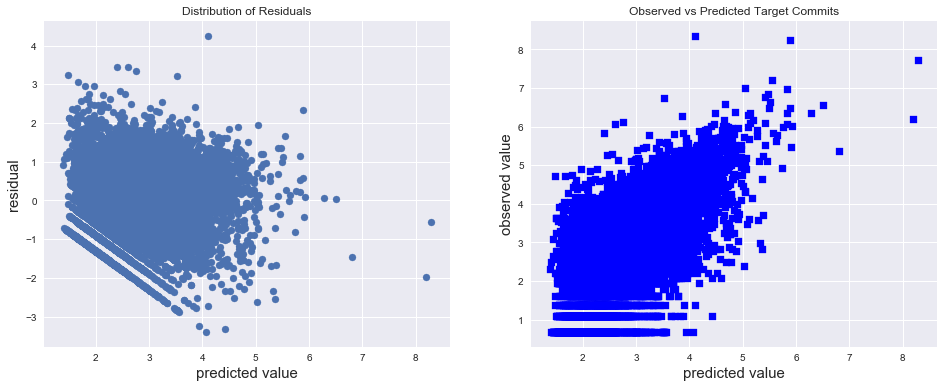

In [229]:
# Check the goodness of fit of the Ridge Regressor 

# let's look at the residuals as well
fig = plt.figure(figsize = (16,6))
preds = pd.DataFrame({"preds":y_pred_reg, "true": y_test_reg})
preds["residuals"] = preds["true"] - preds["preds"]
ax1 = fig.add_subplot(1,2,1); ax1.set_title('Distribution of Residuals')
plt.xlabel('predicted value'); plt.ylabel('residual')
ax1.scatter(x = preds["preds"], y = preds["residuals"])

# See observed and predicted outcome values 
ax2 = fig.add_subplot(1,2,2); ax2.set_title('Observed vs Predicted Target Commits')
ax2.scatter(x = y_pred_reg, y = y_test_reg, c = "blue", marker = "s")
plt.xlabel('predicted value'); plt.ylabel('observed value'); plt.show()

Residual analysis suggest that the fitting of the Rifge Regressor be accptable. 

### 5.2 ZIG Step 2 

Fit a Random Forest Clafier using instances from Train Subsets (i.e., X_Train and y_Train) to predict if an isntance would have target_commits of zero or not (i.e., target_positive = 0 or 1). 

In [237]:
# Split data into Training and Validation subsets 
X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc = train_test_split(X_Train[FEATURES], y_Train['target_positive'], 
                                                                    test_size = 0.3, random_state = 123)
# Instantiate random forest classifier object
zig_rfc = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=10, random_state=123)

# Fit to the training subset
zig_rfc.fit(X_train_rfc, y_train_rfc)

# Predict on test data
y_pred_rfc = zig_rfc.predict(X_test_rfc)
pd.crosstab(y_test_rfc, y_pred_rfc, rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,1914,1163
1,614,6785


The Random Forest Classifier (RFC) of the ZIG Model has an accuracy about 83%, which looks good. The FNR (false negative rate) is a bit high, 24%.

### 5.3 ZIG Step 3

Finally, we use the instances in Validation Sets (i.e., X_Validate and y_Validate) to estimate the performance of this ZIG modeling approach with RMSE measuring the accuracy.

In [250]:
# Use fitted Random Forest Classifier to predict positivity of instances in Validation Data set 
y_preds_val = zig_rfc.predict(X_Validate[FEATURES])
y_predicted_val = pd.DataFrame(y_preds_val) 
y_predicted_val.columns = ['target_positive']

# Use fitted Ridge Regressor predict Target_Commits of instances in the Validation Data set
y_preds_lasso = ridge_reg.predict(X_Validate[FEATURES])
y_predicted_val['target_commits'] = pd.DataFrame(y_preds_lasso)

# If the account is predicted with be inactive, then target_commits is set to zero 
y_predicted_val['target_commits'] *= y_predicted_val['target_positive']  

# Check the RMSE of the ZIG Modeling 
rmse = np.sqrt( mean_squared_error(y_Validate.target_commits, y_predicted_val.target_commits) )
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 1.16310041903


Recall that a simple Random Forest Regressor (RFR) in our Exploratory Analyses can achieve RMSE as lower as 1.07.  RFR is an emsemble learner based on regression trees with Bootstrap resampling method. It does not not need to assume any distribution of the target variable and very convinient to apply out-of-the-box.  

### 6. Predict Target Commits for the Test_Data for Final Submission

In [254]:
# Fit to the training set
rf_reg = RandomForestRegressor(max_depth = 30, n_estimators=100, random_state= 123)
rf_reg.fit(X_Train[FEATURES], y_Train['target_commits'])

# Predict on new data
y_pred_rfr = rf_reg.predict(X_Validate[FEATURES])

# Compute and print the metrics
r2 = rf_reg.score(X_Validate[FEATURES], y_Validate['target_commits'])
print("R squared: {}".format(r2))

rmse = np.sqrt( mean_squared_error(y_Validate['target_commits'], y_pred_rfr) )
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 1.0733320182


### 7. Make Final Prediction for Submission 

In [310]:
# Make predictions using RFR
y_preds_rfr = np.exp(rf_reg.predict(Test_X_Data[FEATURES]))-1.0
y_predicted = pd.DataFrame(y_preds_rfr)

# Create the Submission Data Set
final_results = pd.concat([pd.DataFrame(Test_X_Data.index), y_predicted.astype(int)], axis=1)
final_results.columns = ['huid', 'target_commits']
final_results[['huid', 'target_commits']] = final_results[['huid', 'target_commits']].astype(int)
final_results.to_csv("final_output.csv", index=False)